In [1]:
#!pip install imblearn

In [2]:
#!pip install lightgbm

In [3]:
!pip install pipeline

  Could not find a version that satisfies the requirement pipeline (from versions: )
No matching distribution found for pipeline
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
from imblearn.over_sampling import ADASYN, SMOTE
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
#from sklearn.pipeline import PipeLine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve,precision_recall_curve, precision_score, confusion_matrix, classification_report

Using TensorFlow backend.


## Baseline model

In [15]:
df = pd.read_csv('df_binary.csv')

### Pre-processing

We first remove the variables which we are not going to use in our model. These are variables that only provide information about the collision incident once it has occurred. Hence they cannot be used for predicting the severity of future collisions. 

In [16]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Date','Collision Type','Unnamed: 0'],axis=1)

df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Num People Square,Day of the Week
0,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Daylight,12,15,48.0,2.36674,0.56104,Riverton,4,Wednesday
1,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,85.0,-1.00000,0.36276,Seattle,1,Sunday
2,Block,Not Severe,Mid-Block (not related to intersection),Overcast,Dry,Daylight,12,13,13.0,-1.00000,0.36276,Seattle,4,Monday
3,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,58.0,0.00000,1.73291,Seattle,4,Thursday
4,Block,Not Severe,Mid-Block (not related to intersection),Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,17,55.0,1.57819,0.74738,White Center,4,Friday


### Model 1 - With label encoding and weather variables

In [17]:
le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Weather'] = le.fit_transform(df_binary_base_model['Weather'])
df_binary_base_model['Road Condition'] = le.fit_transform(df_binary_base_model['Road Condition'])
df_binary_base_model['Light Condition'] = le.fit_transform(df_binary_base_model['Light Condition'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))

df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Num People Square,Day of the Week
0,0,0,4,2,3,2,3,7,48.0,2.36674,0.56104,7,4,6
1,0,0,4,2,3,1,3,12,85.0,-1.00000,0.36276,8,1,3
2,0,0,4,1,0,2,3,5,13.0,-1.00000,0.36276,8,4,1
3,0,0,4,2,3,1,3,12,58.0,0.00000,1.73291,8,4,4
4,0,0,4,0,0,1,3,9,55.0,1.57819,0.74738,11,4,0


In [18]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204908, 13)
(204908,)


In [19]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (x_train.head())

(143435, 13)
(61473, 13)
(143435,)
(61473,)
        Address Type  Junction Type  Weather  Road Condition  Light Condition  \
7356               1              1        0               0                2   
115275             1              1        0               0                2   
125588             0              4        4               2                4   
166522             1              1        0               0                2   
18389              0              4        0               0                2   

        Month  Hour  Speed  Road Congestion  Road Length  Neighborhood  \
7356        7     7   20.0         -1.00000      0.36276             8   
115275      6     9   53.0          2.80507      0.38026             8   
125588      3     0   58.0          2.35247      0.63395             8   
166522      6     7   41.0         -1.00000      1.24014             9   
18389      10     0   73.0          2.36674      0.56104             0   

        Num People Squar

In [20]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141175), (1, 141387)]


In [21]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [22]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
auc = roc_auc_score(y_test,prediction)
print (auc)
print (pd.Series(y_test).value_counts())
print (pd.Series(prediction).value_counts())

0.9842207147853529
0.9842207147853529
0.9842207147853529
0.9842207147853529
0.5
0    60503
1      970
Name: Severity Description, dtype: int64
0    61473
dtype: int64


In [91]:
class_report = classification_report(list(y_test),list(prediction))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
print (class_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     60503
           1       0.00      0.00      0.00       970

    accuracy                           0.98     61473
   macro avg       0.49      0.50      0.50     61473
weighted avg       0.97      0.98      0.98     61473



In [23]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.677
Not severe class ROC AUC=0.323


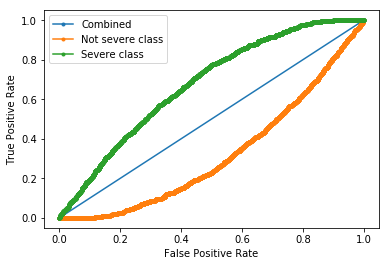

In [24]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [125]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [25]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

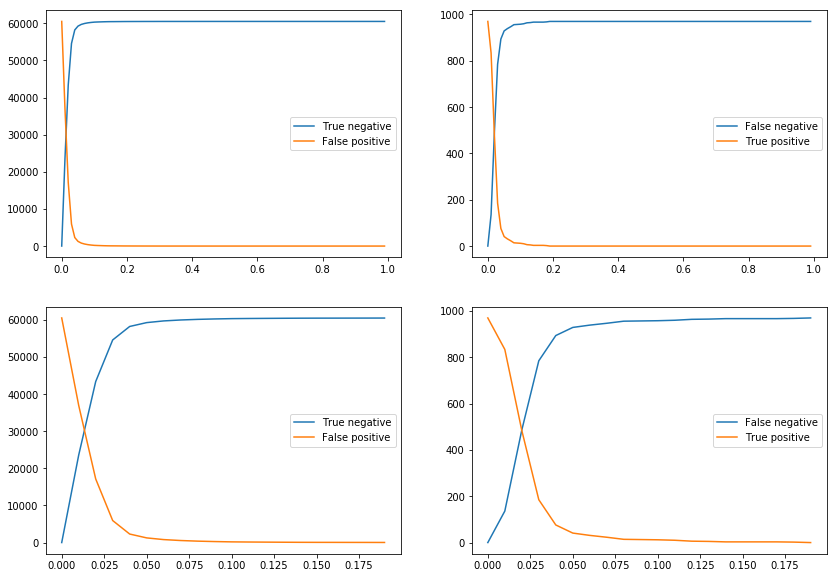

In [26]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

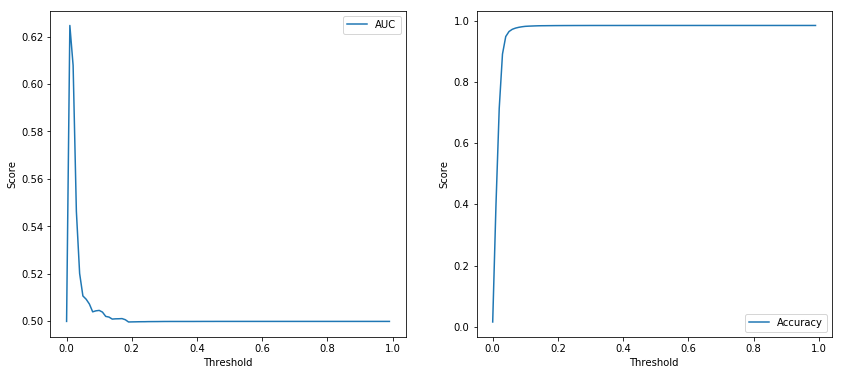

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

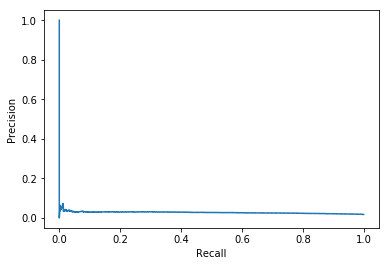

In [28]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [93]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60503 0 970 0


### Model 2 - With label encoding | excluding weather variables and neighborhood

This model provided the best severe class AUC: 0.654

Variables included: 
- Address Type
- Junction Type
- Month 
- Date
- Hour
- Speed
- Road Congestion
- Road Length
- Day of the Week

In [201]:
df = pd.read_csv('df_binary.csv')

In [211]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Date,Hour,Speed,Road Congestion,Road Length,Day of the Week
0,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Daylight,12,12,15,48.0,2.36674,0.56104,Wednesday
1,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,16,2,85.0,-1.00000,0.36276,Sunday
2,Block,Not Severe,Mid-Block (not related to intersection),Overcast,Dry,Daylight,12,17,13,13.0,-1.00000,0.36276,Monday
3,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,20,2,58.0,0.00000,1.73291,Thursday
4,Block,Not Severe,Mid-Block (not related to intersection),Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,14,17,55.0,1.57819,0.74738,Friday


In [212]:
le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Month,Date,Hour,Speed,Road Congestion,Road Length,Day of the Week
0,0,0,4,3,12,7,48.0,2.36674,0.56104,6
1,0,0,4,3,16,12,85.0,-1.00000,0.36276,3
2,0,0,4,3,17,5,13.0,-1.00000,0.36276,1
3,0,0,4,3,20,12,58.0,0.00000,1.73291,4
4,0,0,4,3,14,9,55.0,1.57819,0.74738,0


In [213]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204783, 9)
(204783,)


In [214]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

(143348, 9)
(61435, 9)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [215]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [207]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012


0    61435
dtype: int64

In [54]:
print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435



In [115]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60467 1 967 0


In [208]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.654
Not severe class ROC AUC=0.346


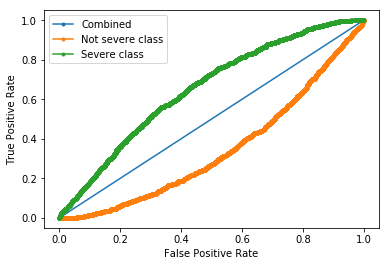

In [216]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [129]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

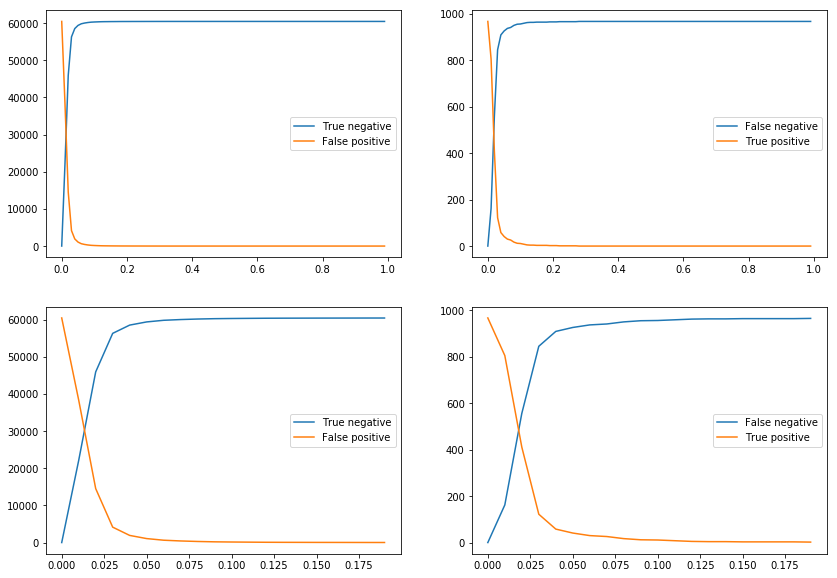

In [130]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

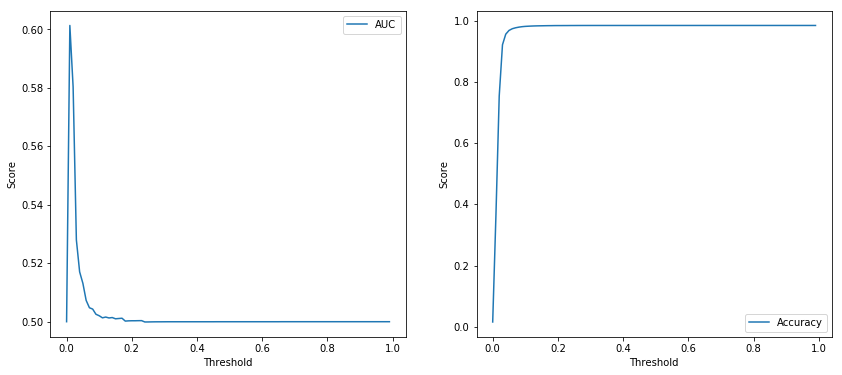

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

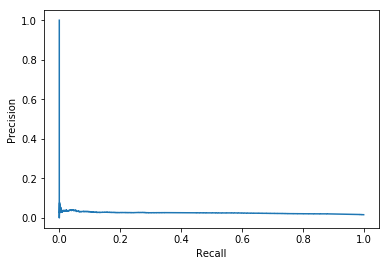

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

           Feature  Importance
5            Speed         533
7      Road Length         461
3             Date         433
4             Hour         414
6  Road Congestion         386
2            Month         325
8  Day of the Week         252
1    Junction Type         162
0     Address Type          34


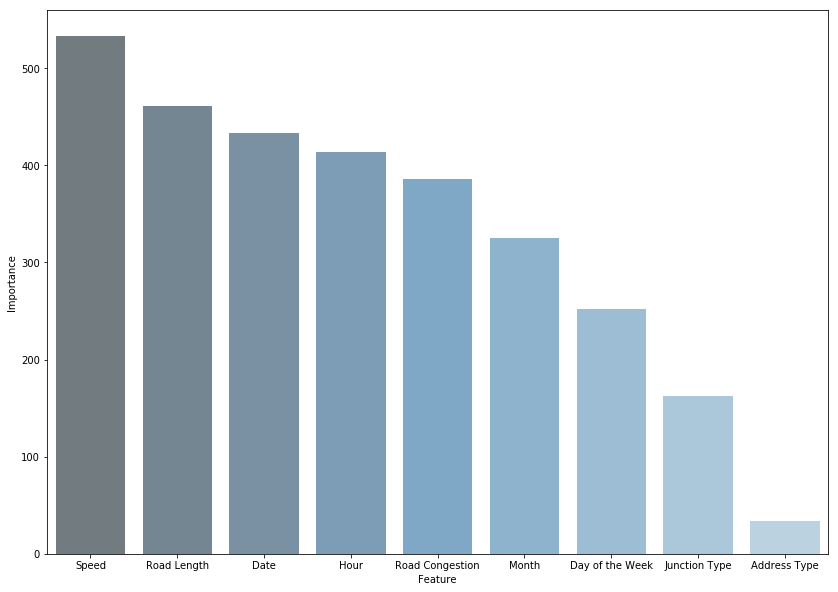

In [147]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

In [106]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(x_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), roc_auc_score(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: continuous format is not supported

### Model 3 - With one hot encoding and without weather variables

In [62]:
df = pd.read_csv('df_binary.csv')

In [63]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Date','Collision Type','Unnamed: 0','Num People Square'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Day of the Week
0,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Daylight,12,15,48.0,2.36674,0.56104,Riverton,Wednesday
1,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,85.0,-1.00000,0.36276,Seattle,Sunday
2,Block,Not Severe,Mid-Block (not related to intersection),Overcast,Dry,Daylight,12,13,13.0,-1.00000,0.36276,Seattle,Monday
3,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,58.0,0.00000,1.73291,Seattle,Thursday
4,Block,Not Severe,Mid-Block (not related to intersection),Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,17,55.0,1.57819,0.74738,White Center,Friday


In [64]:
#One hot encoding
df_ohe = pd.concat((df_binary_base_model[['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Severity Description']],
          pd.get_dummies(df_binary_base_model, columns=['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Severity Description'], drop_first=True)),
          axis=1)
df_ohe.head()

,Address Type,Junction Type,Month,Hour,Neighborhood,Day of the Week,Severity Description,Weather,Road Condition,Light Condition,...,Neighborhood_Tukwila,Neighborhood_White Center,Neighborhood_Yarrow Point,Day of the Week_Monday,Day of the Week_Saturday,Day of the Week_Sunday,Day of the Week_Thursday,Day of the Week_Tuesday,Day of the Week_Wednesday,Severity Description_Severe
0,Block,Mid-Block (not related to intersection),12,15,Riverton,Wednesday,Not Severe,Raining,Wet,Daylight,...,0,0,0,0,0,0,0,0,1,0
1,Block,Mid-Block (not related to intersection),12,2,Seattle,Sunday,Not Severe,Raining,Wet,Dark - Street Lights On,...,0,0,0,0,0,1,0,0,0,0
2,Block,Mid-Block (not related to intersection),12,13,Seattle,Monday,Not Severe,Overcast,Dry,Daylight,...,0,0,0,1,0,0,0,0,0,0
3,Block,Mid-Block (not related to intersection),12,2,Seattle,Thursday,Not Severe,Raining,Wet,Dark - Street Lights On,...,0,0,0,0,0,0,1,0,0,0
4,Block,Mid-Block (not related to intersection),12,17,White Center,Friday,Not Severe,Clear or Partly Cloudy,Dry,Dark - Street Lights On,...,0,1,0,0,0,0,0,0,0,0


In [65]:
df_ohe = df_ohe.drop(['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Weather',
                          'Road Condition','Light Condition','Severity Description'],axis=1)
df_ohe.head()

,Speed,Road Congestion,Road Length,Address Type_Intersection,Junction Type_At Intersection (intersection related),Junction Type_Driveway Junction,Junction Type_Mid-Block (but intersection related),Junction Type_Mid-Block (not related to intersection),Junction Type_Ramp Junction,Junction Type_Unknown,...,Neighborhood_Tukwila,Neighborhood_White Center,Neighborhood_Yarrow Point,Day of the Week_Monday,Day of the Week_Saturday,Day of the Week_Sunday,Day of the Week_Thursday,Day of the Week_Tuesday,Day of the Week_Wednesday,Severity Description_Severe
0,48.0,2.36674,0.56104,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,85.0,-1.00000,0.36276,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,13.0,-1.00000,0.36276,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,58.0,0.00000,1.73291,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,55.0,1.57819,0.74738,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [66]:
X = df_ohe.drop('Severity Description_Severe',axis=1)
Y = df_ohe['Severity Description_Severe']
print (X.shape)
print (Y.shape)

(204783, 62)
(204783,)


In [67]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.33,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(137204, 62)
(67579, 62)
(137204,)
(67579,)


In [75]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Not Severe', 135113), ('Severe', 134643)]


In [70]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [71]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
#auc = roc_auc_score(y_test,prediction,average=None)
#print (auc)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.984270261471759
0.984270261471759
0.984270261471759
0.984270261471759


0    67579
dtype: int64

In [78]:
class_report = classification_report(list(y_test),list(prediction))

In [79]:
print (class_report)

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     66565
      Severe       0.00      0.00      0.00      1055

    accuracy                           0.98     67620
   macro avg       0.49      0.50      0.50     67620
weighted avg       0.97      0.98      0.98     67620



In [72]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.635
Not severe class ROC AUC=0.365


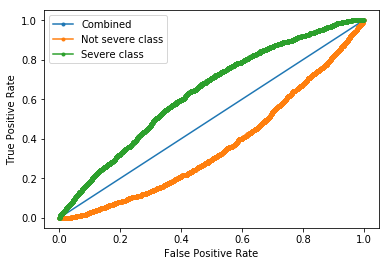

In [73]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [74]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

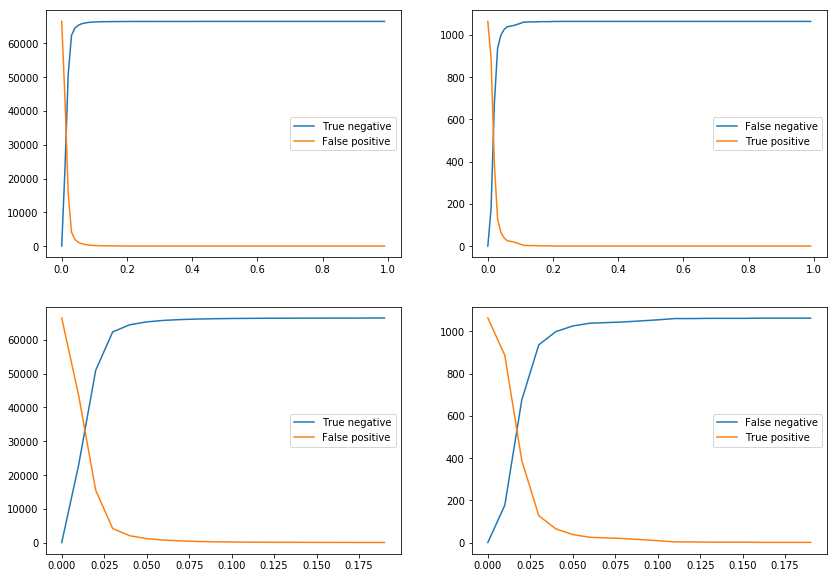

In [75]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

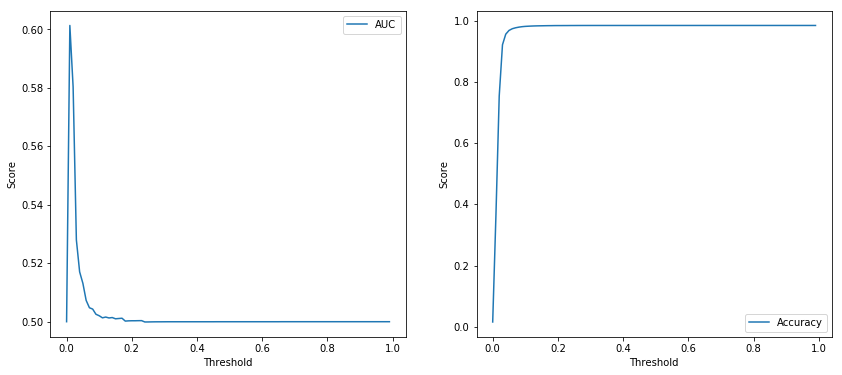

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

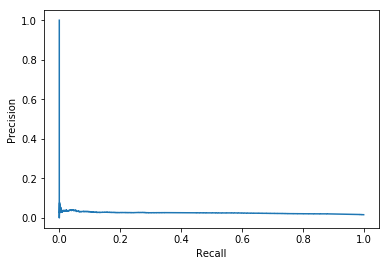

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Model 4 - reduced variables

In [198]:
df = pd.read_csv('df_binary.csv')

### Pre-processing

We first remove the variables which we are not going to use in our model. These are variables that only provide information about the collision incident once it has occurred. Hence they cannot be used for predicting the severity of future collisions. 

In [81]:
'''
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Date','Collision Type','Unnamed: 0','Num People Square'],axis=1)
'''
df_binary_base_model = df[['Severity Description','Road Congestion','Road Length','Speed','Date','Month','Day of the Week','Hour']]
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Road Congestion,Road Length,Speed,Date,Month,Day of the Week,Hour
0,Not Severe,2.36674,0.56104,48.0,12,12,Wednesday,15
1,Not Severe,-1.00000,0.36276,85.0,16,12,Sunday,2
2,Not Severe,-1.00000,0.36276,13.0,17,12,Monday,13
3,Not Severe,0.00000,1.73291,58.0,20,12,Thursday,2
4,Not Severe,1.57819,0.74738,55.0,14,12,Friday,17


In [82]:
le = LabelEncoder()

df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Date'] = le.fit_transform(df_binary_base_model['Date'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))


df_binary_base_model.head()

,Severity Description,Road Congestion,Road Length,Speed,Date,Month,Day of the Week,Hour
0,0,2.36674,0.56104,48.0,3,3,6,7
1,0,-1.00000,0.36276,85.0,7,3,3,12
2,0,-1.00000,0.36276,13.0,8,3,1,5
3,0,0.00000,1.73291,58.0,12,3,4,12
4,0,1.57819,0.74738,55.0,5,3,0,9


In [83]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204783, 7)
(204783,)


In [84]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (x_train.head())

(143348, 7)
(61435, 7)
(143348,)
(61435,)
        Road Congestion  Road Length  Speed  Date  Month  Day of the Week  \
162290          1.49514      1.25377  101.0    25      1                3   
119775          3.59853      0.42997   42.0     6      0                3   
158271         -1.00000      0.43959   44.0    29      2                3   
53546           2.36674      0.56104   35.0    10      4                1   
71791          -1.00000      0.90794   20.0     1      8                5   

        Hour  
162290     0  
119775    23  
158271     5  
53546      3  
71791      4  


In [87]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Not Severe', 141175), ('Severe', 141175)]


In [85]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [86]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
#auc = roc_auc_score(y_test,prediction,average=None)
#print (auc)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
print (pd.Series(y_test).value_counts())
print (pd.Series(prediction).value_counts())

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
0    60468
1      967
Name: Severity Description, dtype: int64
0    61435
dtype: int64


In [36]:
class_report = classification_report(list(y_test),list(prediction))

In [37]:
print (class_report)

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60863
      Severe       1.00      0.98      0.99     60445

    accuracy                           0.99    121308
   macro avg       0.99      0.99      0.99    121308
weighted avg       0.99      0.99      0.99    121308



In [87]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.577
Not severe class ROC AUC=0.423


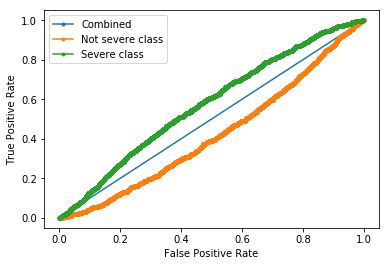

In [88]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [89]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

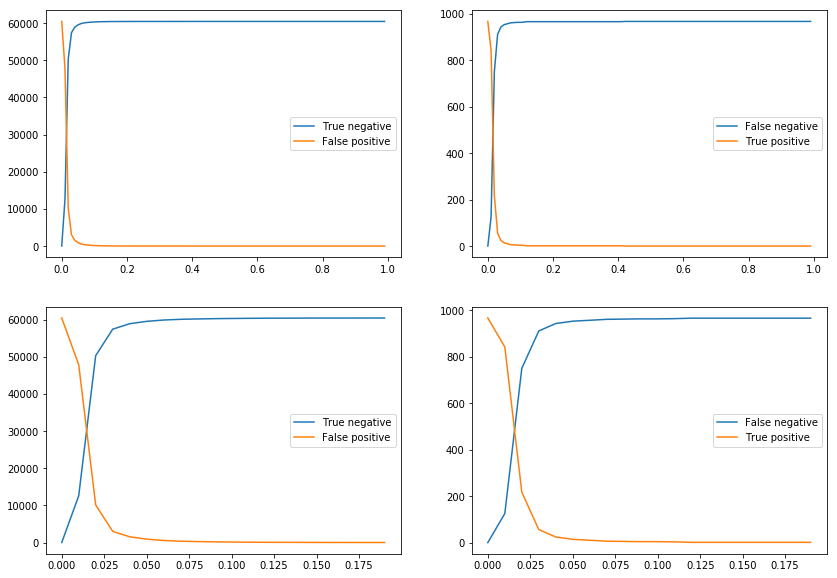

In [90]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

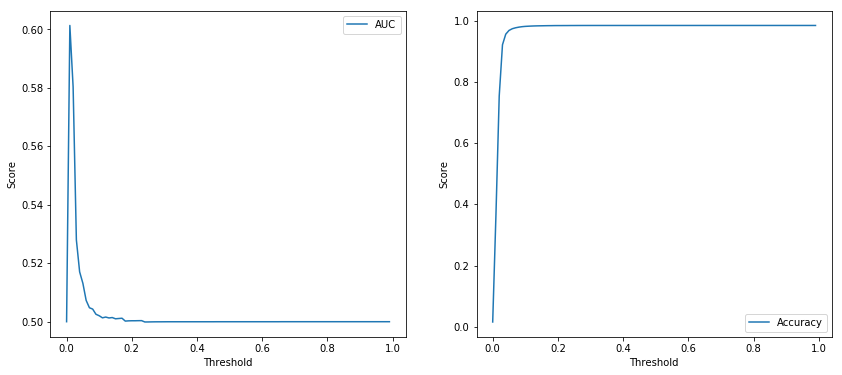

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

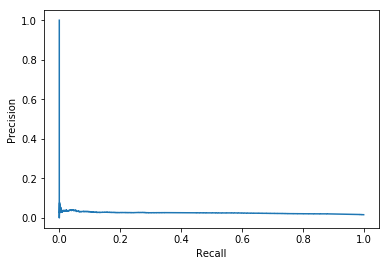

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Model 5 - Only Junction Type and Address Type 

In [198]:
df = pd.read_csv('df_binary.csv')

### Pre-processing

We first remove the variables which we are not going to use in our model. These are variables that only provide information about the collision incident once it has occurred. Hence they cannot be used for predicting the severity of future collisions. 

In [107]:
df_binary_base_model = df[['Severity Description','Junction Type','Address Type']]
#df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Junction Type,Address Type
0,Not Severe,Mid-Block (not related to intersection),Block
1,Not Severe,Mid-Block (not related to intersection),Block
2,Not Severe,Mid-Block (not related to intersection),Block
3,Not Severe,Mid-Block (not related to intersection),Block
4,Not Severe,Mid-Block (not related to intersection),Block


In [108]:
le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'])

df_binary_base_model.head()

,Severity Description,Junction Type,Address Type
0,0,4,0
1,0,4,0
2,0,4,0
3,0,4,0
4,0,4,0


In [109]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(205394, 2)
(205394,)


In [110]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(143775, 2)
(61619, 2)
(143775,)
(61619,)


In [106]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141495), (1, 141495)]


In [111]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [112]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
#auc = roc_auc_score(y_test,prediction,average=None)
#print (auc)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9845015336178776
0.9845015336178776
0.9845015336178776
0.9845015336178776


0    61619
dtype: int64

In [99]:
class_report = classification_report(list(y_test),list(prediction))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
print (class_report)

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60664
      Severe       0.00      0.00      0.00       955

    accuracy                           0.98     61619
   macro avg       0.49      0.50      0.50     61619
weighted avg       0.97      0.98      0.98     61619



In [113]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.603
Not severe class ROC AUC=0.397


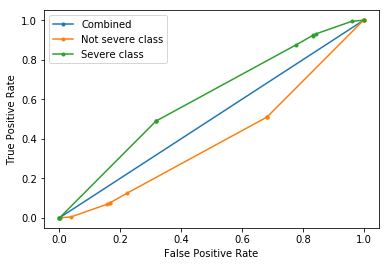

In [114]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [115]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

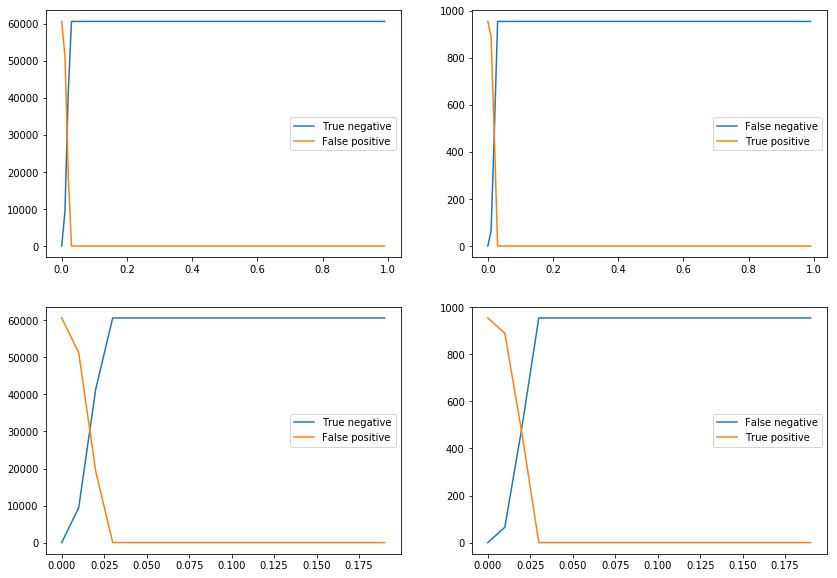

In [116]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

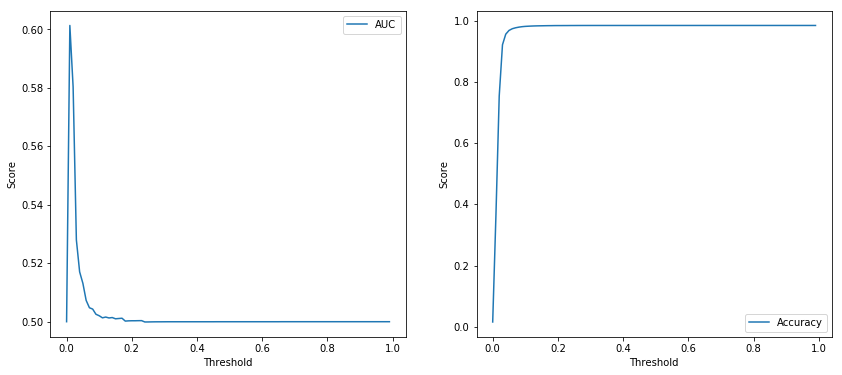

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

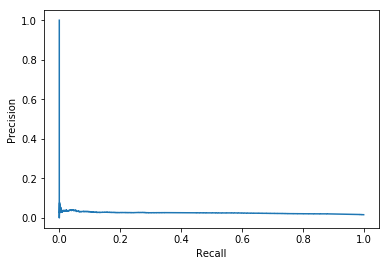

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Model 6 - With label encoding | excluding weather variables, neighborhood, address type and junction type

This model provided the best severe class AUC: 0.654

Variables included: 
- Address Type
- Junction Type
- Month 
- Date
- Hour
- Speed
- Road Congestion
- Road Length
- Day of the Week

In [148]:
df = pd.read_csv('df_binary.csv')

In [149]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Address Type','Junction Type'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Weather,Road Condition,Light Condition,Month,Date,Hour,Speed,Road Congestion,Road Length,Day of the Week
0,Not Severe,Raining,Wet,Daylight,12,12,15,48.0,2.36674,0.56104,Wednesday
1,Not Severe,Raining,Wet,Dark - Street Lights On,12,16,2,85.0,-1.00000,0.36276,Sunday
2,Not Severe,Overcast,Dry,Daylight,12,17,13,13.0,-1.00000,0.36276,Monday
3,Not Severe,Raining,Wet,Dark - Street Lights On,12,20,2,58.0,0.00000,1.73291,Thursday
4,Not Severe,Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,14,17,55.0,1.57819,0.74738,Friday


In [150]:
le = LabelEncoder()
#df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
#df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

df_binary_base_model.head()

,Severity Description,Month,Date,Hour,Speed,Road Congestion,Road Length,Day of the Week
0,0,3,12,7,48.0,2.36674,0.56104,6
1,0,3,16,12,85.0,-1.00000,0.36276,3
2,0,3,17,5,13.0,-1.00000,0.36276,1
3,0,3,20,12,58.0,0.00000,1.73291,4
4,0,3,14,9,55.0,1.57819,0.74738,0


In [151]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204783, 7)
(204783,)


In [152]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

(143348, 7)
(61435, 7)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [153]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [154]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9842760641328233
0.9842760641328233
0.9842760641328233
0.9842760641328233


0    61434
1        1
dtype: int64

In [54]:
print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435



In [115]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60467 1 967 0


In [155]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.500517063081696


Combined ROC AUC=0.501
Severe class ROC AUC=0.588
Not severe class ROC AUC=0.412


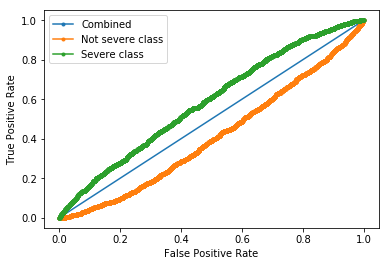

In [156]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [157]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

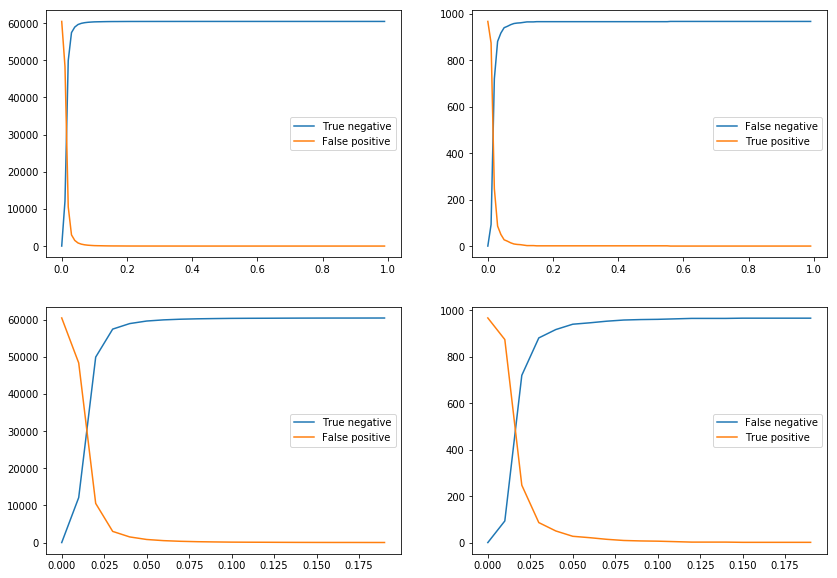

In [158]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

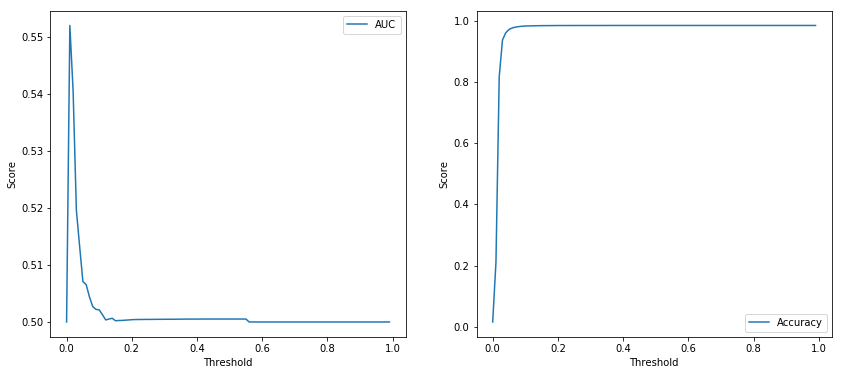

In [159]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

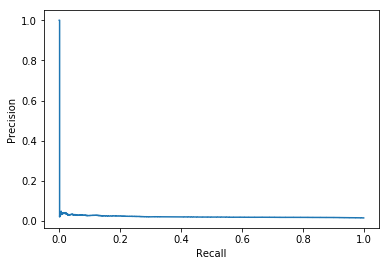

In [160]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

           Feature  Importance
3            Speed         538
1             Date         522
5      Road Length         491
4  Road Congestion         454
2             Hour         382
0            Month         339
6  Day of the Week         274


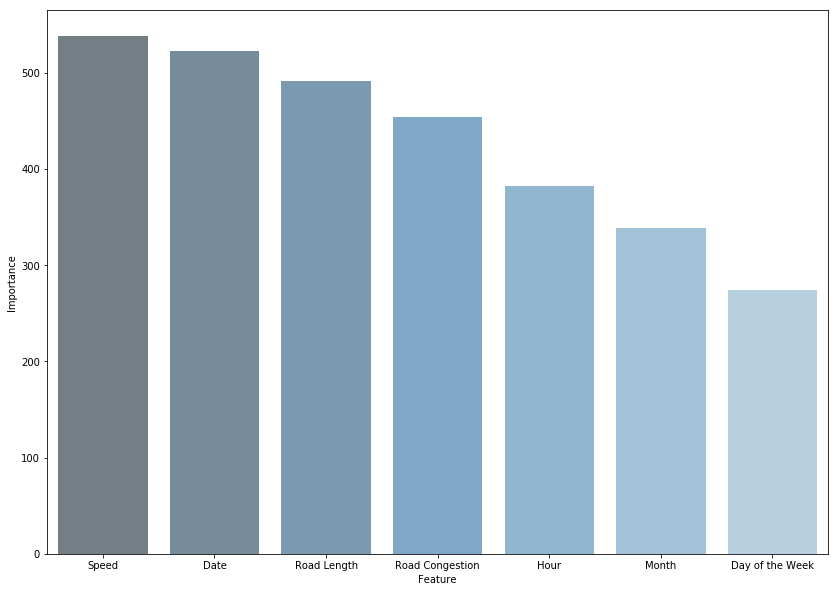

In [161]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

### Model 7 - With label encoding | only Speed, Road Length, Date, Hour, Road Congestion

In [162]:
df = pd.read_csv('df_binary.csv')

In [166]:
df_binary_base_model = df[['Severity Description','Speed','Road Length','Date','Hour','Road Congestion']]
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Speed,Road Length,Date,Hour,Road Congestion
0,Not Severe,48.0,0.56104,12,15,2.36674
1,Not Severe,85.0,0.36276,16,2,-1.00000
2,Not Severe,13.0,0.36276,17,13,-1.00000
3,Not Severe,58.0,1.73291,20,2,0.00000
4,Not Severe,55.0,0.74738,14,17,1.57819


In [167]:
le = LabelEncoder()
#df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
#df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
#df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
#df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))

df_binary_base_model.head()

,Severity Description,Speed,Road Length,Date,Hour,Road Congestion
0,0,48.0,0.56104,12,7,2.36674
1,0,85.0,0.36276,16,12,-1.00000
2,0,13.0,0.36276,17,5,-1.00000
3,0,58.0,1.73291,20,12,0.00000
4,0,55.0,0.74738,14,9,1.57819


In [168]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204783, 5)
(204783,)


In [169]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

(143348, 5)
(61435, 5)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [170]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [171]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012


0    61435
dtype: int64

In [54]:
print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435



In [115]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60467 1 967 0


In [172]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.581
Not severe class ROC AUC=0.419


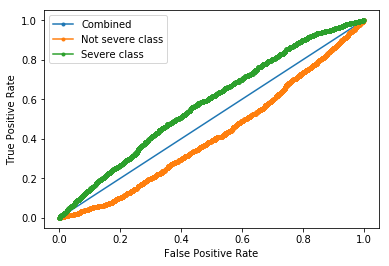

In [173]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [174]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
error_rate = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    error_rate.append((fp+fn)/(tp+fp+tn+fn))
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

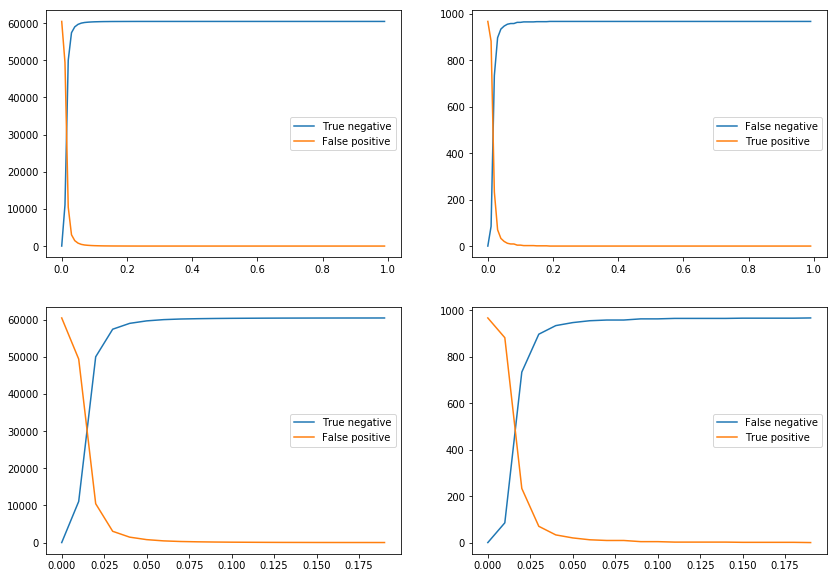

In [175]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

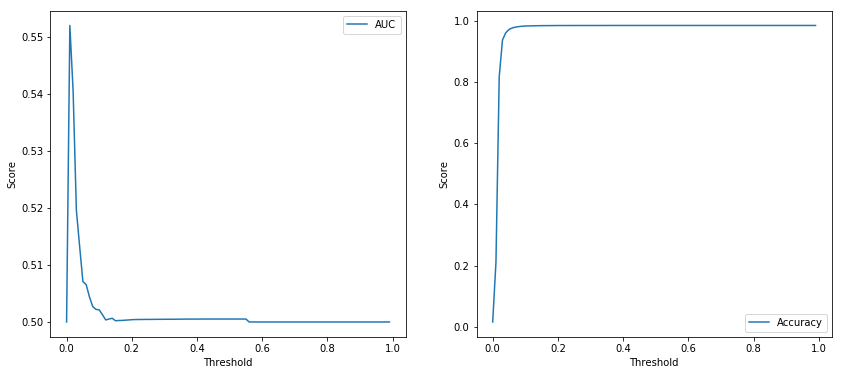

In [159]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

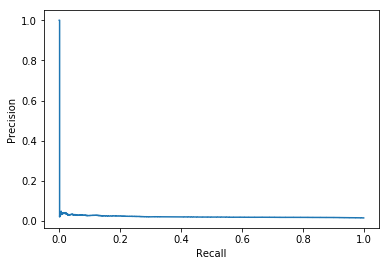

In [160]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

           Feature  Importance
0            Speed         674
2             Date         661
4  Road Congestion         583
1      Road Length         575
3             Hour         507


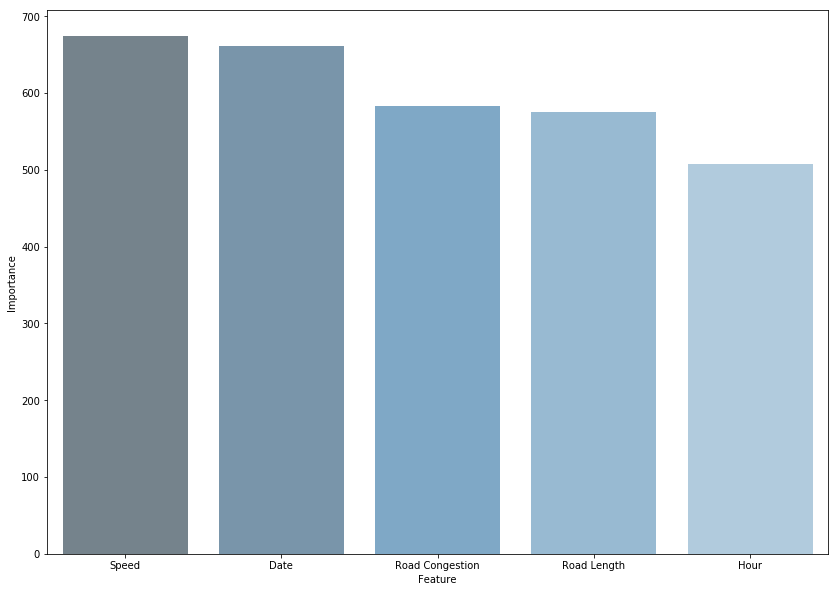

In [176]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

### Model 8 - Logistic Regression | With label encoding | excluding weather variables and neighborhood

(204783, 8)
(204783,)
(143348, 8)
(61435, 8)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0
0.5


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.629
Not severe class ROC AUC=0.371


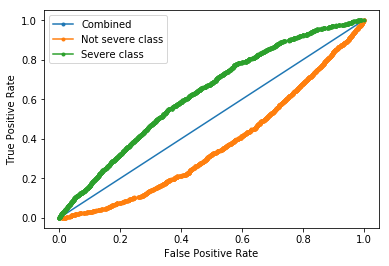

In [200]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lr = LogisticRegression(C=1)
model = lr.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [193]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

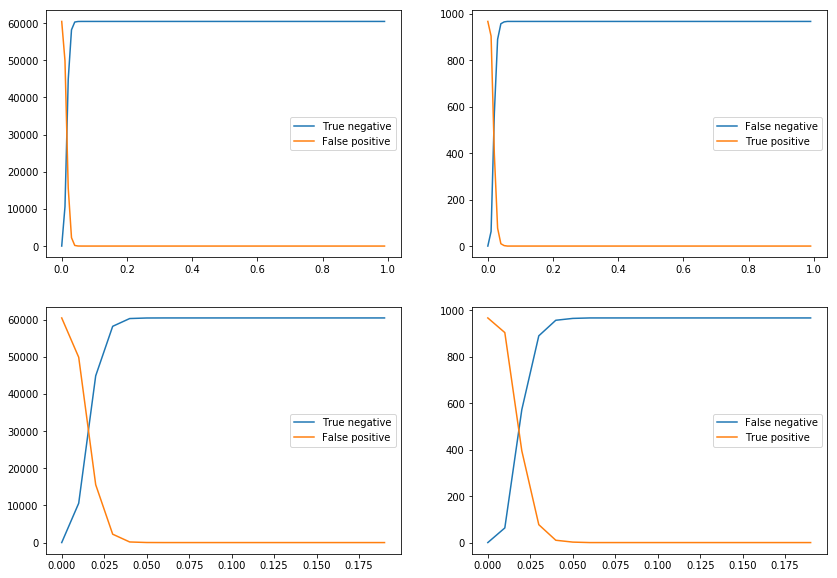

In [190]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

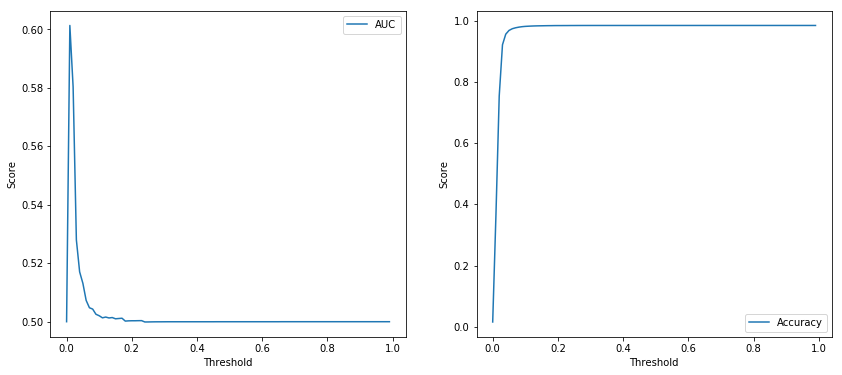

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

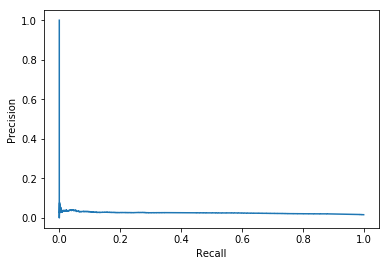

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

           Feature  Importance
5            Speed         533
7      Road Length         461
3             Date         433
4             Hour         414
6  Road Congestion         386
2            Month         325
8  Day of the Week         252
1    Junction Type         162
0     Address Type          34


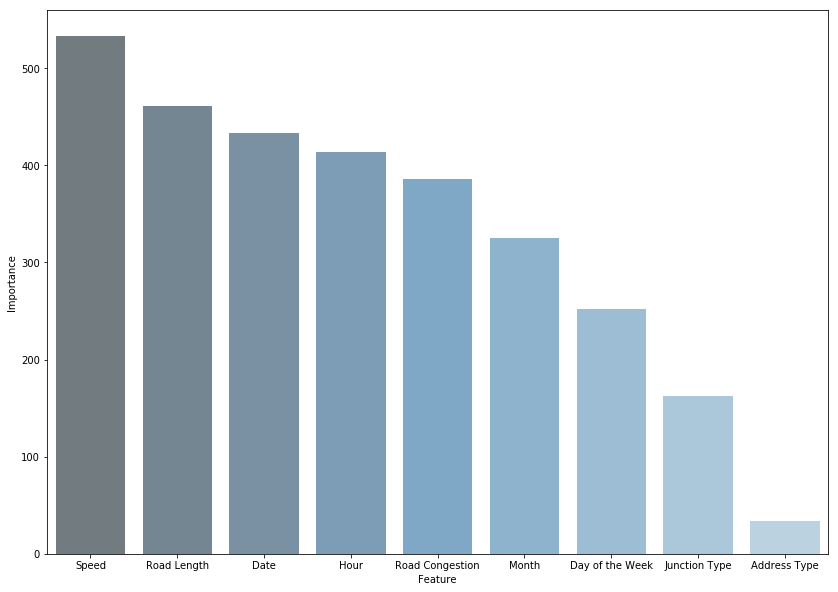

In [147]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

### Model 9 - Random Forest

(204783, 8)
(204783,)
(143348, 8)
(61435, 8)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9840644583706356
0.9840644583706356
0.9840644583706356
0.9840644583706356
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60456 12 967 0
0.4999007739630879
Combined ROC AUC=0.500
Severe class ROC AUC=0.521
Not severe class ROC AUC=0.479


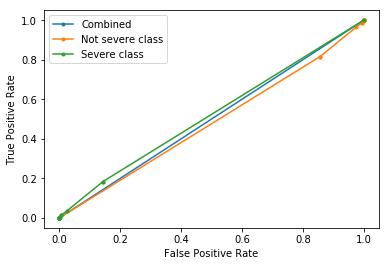

In [6]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
rf = RandomForestClassifier()
model = rf.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Grid Search - LightGBM

In [37]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

(204783, 8)
(204783,)


In [69]:
from sklearn.model_selection import GridSearchCV
#pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

params = {'max_depth' : [5],
    'num_leaves':[10,30,50],
         'learning_rate':[0.001,0.003,0.005,0.01],
         'min_data_in_leaf':[1000,2000,5000,10000,50000],
         'objective':['binary'],
         }

# Create grid search object
lgb = LGBMClassifier()
clf = GridSearchCV(lgb, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


In [70]:
print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
clf.cv_results_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=1000, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=30, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
0.6397568831048397
{'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 1000, 'num_leaves': 30, 'objective': 'binary'}


{'mean_fit_time': array([0.74279494, 0.86531172, 0.86795535, 0.75243783, 0.89106088,
        0.87741251, 0.78903737, 0.85767875, 0.85607781, 0.77297115,
        0.73697615, 0.73035007, 0.48356581, 0.48331614, 0.48117104,
        0.74591851, 0.85793467, 0.8537374 , 0.75686135, 0.88622313,
        0.87951307, 0.78819218, 0.85841022, 0.85121613, 0.7249547 ,
        0.73372698, 0.7304656 , 0.47972789, 0.48227644, 0.48071618,
        0.74792295, 0.85375366, 0.85530066, 0.75806966, 0.87342253,
        0.87470188, 1.2032176 , 0.84759264, 0.84877915, 0.73278875,
        0.73569345, 0.73232217, 0.48174376, 0.48183188, 0.48266125,
        0.74409947, 0.84702802, 0.85089889, 0.76166644, 0.86445866,
        0.86097007, 0.77980957, 0.85107756, 0.84802885, 0.73687582,
        0.73402853, 0.73214736, 0.4843256 , 0.48015265, 0.48226581]),
 'std_fit_time': array([0.01662964, 0.01605373, 0.013989  , 0.00717378, 0.02176541,
        0.01873385, 0.01170945, 0.03126962, 0.02750451, 0.06082084,
        0.036

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.659
Not severe class ROC AUC=0.341


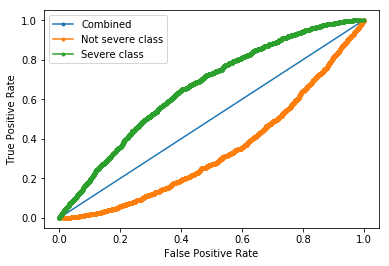

In [72]:
lgb = LGBMClassifier(num_leaves=50, max_depth=5,objective='binary')

model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

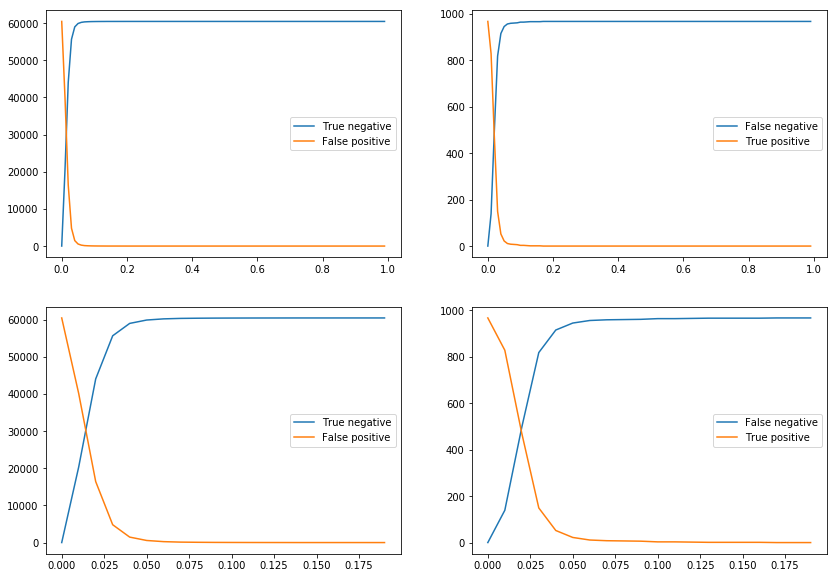

In [73]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

#### Re-running LightGBM grid search with standard scaling and proper categorization of discrete variables

In [ ]:
# Label encode categorical variables.

label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

hour_order = ['0','1','2','3','4','5','6']
month_order = ['jan','feb','mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri','sat','sun']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for occupation
X_df = pd.concat([X_df, pd.get_dummies(X_df['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(X_df, 'education', educ_order)
ordered_labels(X_df, 'month', month_order)
ordered_labels(X_df, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(X_df):
    if X_df[col].dtype == 'object':
        X_df[col] = label_encoder.fit_transform(np.array(X_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X_df.head()

In [82]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

(204783, 8)
(204783,)


In [83]:
# Normalizing continuous variables

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.660
Not severe class ROC AUC=0.340


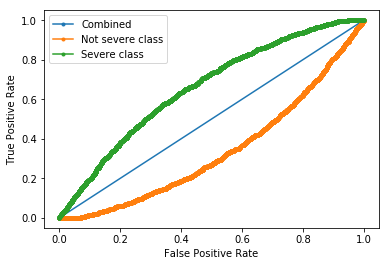

In [85]:
#lgb = LGBMClassifier(num_leaves=50, max_depth=5,objective='binary')
lgb = LGBMClassifier(num_leaves=10, max_depth=5,objective='binary')

model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [86]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
error_rate = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    error_rate.append((fp+fn)/(tp+fp+tn+fn))
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

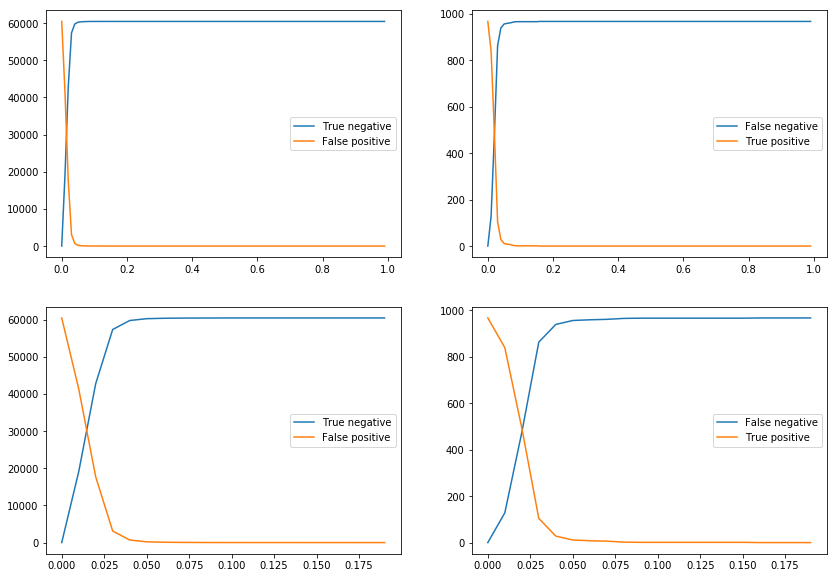

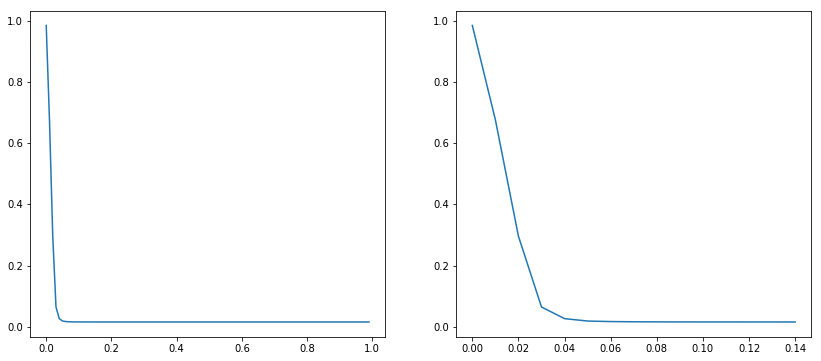

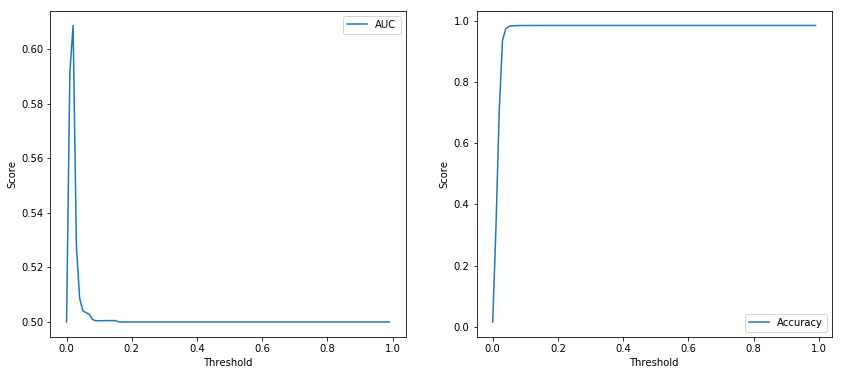

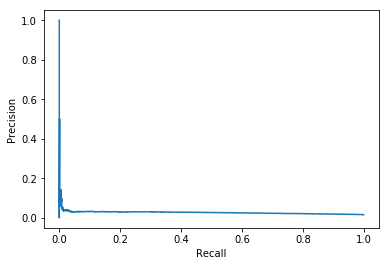

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [93]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,error_rate,label='Misclassification error')
plt.subplot(1,2,2)
plt.plot(threshold[:15],error_rate[:15],label='Misclassification error zoomed in')

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

In [102]:
predictions = (lr_probs[:,1]>0.02).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
error_rate = (fp+fn)/(tp+fp+tn+fn)
print (error_rate)
print (tn,fp,fn,tp)

0.2957760234394075
42771 17697 474 493


In [79]:
from sklearn.model_selection import GridSearchCV
#pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

params = {'max_depth' : [5],
    'num_leaves':[10,30,50],
         'learning_rate':[0.001,0.003,0.005,0.01,0.1],
         'min_data_in_leaf':[1000,2000,5000,10000,50000],
         'objective':['binary'],
         }

# Create grid search object
lgb = LGBMClassifier()
clf = GridSearchCV(lgb, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  5.0min finished


In [80]:
print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
clf.cv_results_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=1000, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
0.644663277292189
{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 1000, 'num_leaves': 10, 'objective': 'binary'}


{'mean_fit_time': array([0.7315485 , 0.85799665, 1.24248695, 0.74315019, 0.95158997,
        0.87816153, 0.77512589, 0.851091  , 0.85211558, 0.71399527,
        0.71819291, 0.71726036, 0.47129927, 0.47923512, 0.47335548,
        0.73234529, 0.84746828, 0.84937453, 0.74629607, 0.86982198,
        0.86981659, 0.77493796, 0.84396315, 0.84542441, 0.72263331,
        0.72143645, 0.7180809 , 0.47212386, 0.47302632, 0.47709584,
        0.73429866, 0.84601903, 0.84718161, 0.74640107, 0.86798167,
        0.87763042, 0.78051434, 0.84245353, 0.84313612, 0.72320704,
        0.72235084, 0.72586803, 0.47497969, 0.47224126, 0.47138696,
        0.73506823, 0.88531952, 1.2117938 , 0.74352293, 0.85097165,
        0.8547792 , 0.77201266, 0.83936901, 0.84286785, 0.72628651,
        0.72421951, 0.72264028, 0.47334313, 0.47589698, 0.4706737 ,
        0.64052052, 0.70981379, 0.71579714, 0.66093631, 0.72004089,
        0.71799746, 0.7066896 , 0.73108802, 0.72739048, 0.70372987,
        0.6993444 , 0.69835577,

### Grid Search - logistic regression

In [29]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

(204783, 8)
(204783,)


In [30]:
from sklearn.model_selection import GridSearchCV
#pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

params = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}

# Create grid search object
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


In [36]:
print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
clf.cv_results_

LogisticRegression(C=206.913808111479, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
0.6202888545549682
{'C': 206.913808111479, 'penalty': 'l1', 'solver': 'liblinear'}


{'mean_fit_time': array([0.25041385, 0.29090176, 0.30841312, 0.3549696 , 0.31403804,
        0.37366009, 0.46800909, 0.44870906, 0.5778192 , 0.48925762,
        0.63003645, 0.53481259, 0.58779254, 0.61274133, 1.02250934,
        0.69801836, 1.10026751, 0.71698289, 1.29695659, 0.75461788,
        1.17017136, 0.73960147, 1.27679725, 0.77745786, 1.15985394,
        0.76039491, 1.1994617 , 0.76590805, 1.16991625, 0.75750389,
        1.2482801 , 0.74231644, 1.27248836, 0.72436657, 1.33535848,
        0.81479979, 1.18041611, 0.75169029, 1.14459119, 0.75420256]),
 'std_fit_time': array([0.01229362, 0.01403423, 0.02571309, 0.00605232, 0.01809385,
        0.00136133, 0.02816152, 0.01073399, 0.05843281, 0.00879109,
        0.08106239, 0.01437742, 0.0399505 , 0.03607584, 0.0802595 ,
        0.01886479, 0.13725641, 0.03334138, 0.19960443, 0.0192746 ,
        0.11393356, 0.02612942, 0.07812674, 0.01752943, 0.1116415 ,
        0.02520775, 0.09654178, 0.02739003, 0.09341613, 0.02105377,
        0.116

### Applying optimized hyperparameters to logistic regression model

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0
0.5


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.629
Not severe class ROC AUC=0.371


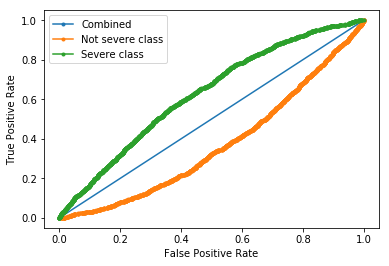

In [35]:
lr = LogisticRegression(C=1438.44988828766,penalty='l1',solver='liblinear')
model = lr.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Splitting train and test data by time period

In [24]:
df_time = pd.read_csv('df_binary.csv')

#Assigning the index to the datetime variable and sorting the data by the index
df_time.index = df_time['Incident Date and Time']
df_time = df_time.sort_index()
df_time.head()

,Unnamed: 0,Longitude,Latitude,Status,Address Type,Severity Description,Collision Type,Number of People Involved,Number of Pedestrians Involved,Number of Bicycles Involved,...,Month,Date,Hour,Minute,Speed,Road Congestion,Road Length,Neighborhood,Num People Square,Day of the Week
Incident Date and Time,,,,,,,,,,,,,,,,,,,,,
2003-10-06 00:00:00,564,-122.320755,47.608073,Matched,Intersection,Not Severe,Unknown,0,0,0,...,10,6,0,0,21.0,-1.0000,0.23056,Seattle,0,Monday
2004-01-01 00:00:00,11945,-122.360959,47.571594,Unmatched,Block,Not Severe,Unknown,0,0,0,...,1,1,0,0,87.0,0.0000,0.61293,Seattle,0,Thursday
2004-01-01 00:00:00,12434,-122.321877,47.605770,Matched,Intersection,Severe,Angles,4,0,0,...,1,1,0,0,27.0,-1.0000,0.23056,Seattle,16,Thursday
2004-01-01 00:00:00,9971,-122.350466,47.613367,Matched,Intersection,Not Severe,Angles,2,0,0,...,1,1,0,0,35.0,3.8431,0.34420,Seattle,4,Thursday
2004-01-01 00:00:00,17351,-122.321448,47.614071,Matched,Block,Not Severe,Sideswipe,5,0,0,...,1,1,0,0,16.0,-1.0000,0.43432,Seattle,25,Thursday


In [25]:
df_time = df_time.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_time = df_time[df_time['Road Length']<900]
df_time = df_time.dropna()

le = LabelEncoder()
df_time['Address Type'] = le.fit_transform(df_time['Address Type'])
df_time['Junction Type'] = le.fit_transform(df_time['Junction Type'])
df_time['Month'] = le.fit_transform(df_time['Month'].map(str))
df_time['Hour'] = le.fit_transform(df_time['Hour'].map(str))
df_time['Day of the Week'] = le.fit_transform(df_time['Day of the Week'])
df_time['Severity Description'] = le.fit_transform(df_time['Severity Description'].map(str))
df_time = df_time.drop(['Weather','Light Condition','Road Condition'],axis=1)

In [26]:
#Splitting the data manually by year
train = df_time[:'2017']
test = df_time['2017':]
print (train.shape)
print (test.shape)
df_time.shape

(173922, 9)
(30861, 9)


(204783, 9)

In [56]:
train_df = pd.DataFrame()
train_df['Count'] = train.groupby('Severity Description')['Month'].count()
train_df['Rate'] = train_df['Count'].apply(lambda x: (x/sum(train_df['Count']))*100)

test_df = pd.DataFrame()
test_df['Count'] = test.groupby('Severity Description')['Month'].count()
test_df['Rate'] = test_df['Count'].apply(lambda x: (x/sum(test_df['Count']))*100)
print (train_df)
print (test_df)

                       Count       Rate
Severity Description                   
0                     171203  98.436656
1                       2719   1.563344
                      Count       Rate
Severity Description                  
0                     30351  98.347429
1                       510   1.652571


Above we confirm that the event rates for each class across both splits are somewhat the same. This is important for modeling. 

In [57]:
x_train = train.drop('Severity Description',axis=1)
y_train = train['Severity Description']
x_test = test.drop('Severity Description',axis=1)
y_test = test['Severity Description']
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(173922, 8)
(173922,)
(30861, 8)
(30861,)


0.9834742879362302
0.9834742879362302
0.9834742879362302
0.9834742879362302
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     30351
      Severe       0.00      0.00      0.00       510

    accuracy                           0.98     30861
   macro avg       0.49      0.50      0.50     30861
weighted avg       0.97      0.98      0.98     30861

30351 0 510 0
Combined ROC AUC=0.500
Severe class ROC AUC=0.635
Not severe class ROC AUC=0.365


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


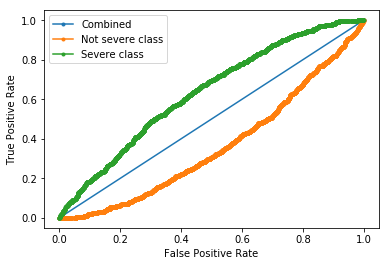

In [62]:
#lgb = LGBMClassifier(num_leaves=50, max_depth=5,objective='binary')
lgb = LGBMClassifier(learning_rate=0.1,num_leaves=10, min_data_in_leaves=1000,max_depth=5,objective='binary')

model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Grid search for time split data

In [59]:
from sklearn.model_selection import GridSearchCV

# Create param grid.
params = {'max_depth' : [5],
    'num_leaves':[10,30,50],
         'learning_rate':[0.001,0.003,0.005,0.01,0.1],
         'min_data_in_leaf':[1000,2000,5000,10000,50000],
         'objective':['binary'],
         }

# Create grid search object
lgb = LGBMClassifier()
clf = GridSearchCV(lgb, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  6.1min finished


In [60]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 1000,
 'num_leaves': 10,
 'objective': 'binary'}

In [61]:
clf.best_score_

0.6459449131854915

In [65]:
print (model.feature_importances_)
print (x_train.columns)

[ 25  93  81  99 164 220 168  50]
Index(['Address Type', 'Junction Type', 'Month', 'Date', 'Hour', 'Speed',
       'Road Length', 'Day of the Week'],
      dtype='object')


### Misclassification error

In [68]:
lr_probs = model.predict_proba(x_test)
predictions = (lr_probs[:,1]>0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
error_rate = (fp+fn)/(tp+fp+tn+fn)
print (error_rate)

0.016525712063769807


In [94]:
predictions = (lr_probs[:,1]>0.025).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
error_rate = (fp+fn)/(tp+fp+tn+fn)
print (error_rate)
print (tn,fp,fn,tp)

0.1393830878163913
52625 7843 720 247


### Experiments

In [75]:
#os.chdir('/home/ec2-user/SageMaker')
df = pd.read_csv('df_binary.csv')
df = df[df['Road Congestion']<900]
df['Speed Squared'] = df['Speed']**2
df.shape

(205269, 35)

### Speed vs Severity

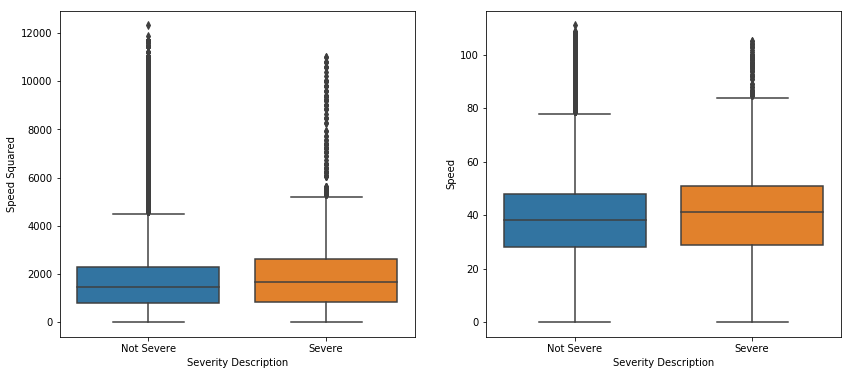

In [79]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(y='Speed Squared',x='Severity Description',data=df)
plt.subplot(1,2,2)
sns.boxplot(y='Speed',x='Severity Description',data=df)
plt.show()

In [80]:
df.head()

,Unnamed: 0,Longitude,Latitude,Status,Address Type,Severity Description,Collision Type,Number of People Involved,Number of Pedestrians Involved,Number of Bicycles Involved,...,Date,Hour,Minute,Speed,Road Congestion,Road Length,Neighborhood,Num People Square,Day of the Week,Speed Squared
0,0,-122.292141,47.536087,Matched,Block,Not Severe,Sideswipe,2,0,0,...,12,15,49,48.0,2.36674,0.56104,Riverton,4,Wednesday,2304.0
1,1,-122.335422,47.598752,Matched,Block,Not Severe,Other,1,0,0,...,16,2,44,85.0,-1.00000,0.36276,Seattle,1,Sunday,7225.0
2,2,-122.331579,47.598746,Matched,Block,Not Severe,Sideswipe,2,0,0,...,17,13,26,13.0,-1.00000,0.36276,Seattle,4,Monday,169.0
3,3,-122.334188,47.571578,Matched,Block,Not Severe,Other,2,0,0,...,20,2,25,58.0,0.00000,1.73291,Seattle,4,Thursday,3364.0
4,5,-122.337348,47.520472,Matched,Block,Not Severe,Sideswipe,2,0,0,...,14,17,33,55.0,1.57819,0.74738,White Center,4,Friday,3025.0


In [191]:
np.corrcoef(df['Road Congestion'],df['Road Length'])

array([[1.        , 0.99732449],
       [0.99732449, 1.        ]])

### Speed vs Road Congestion vs Severity

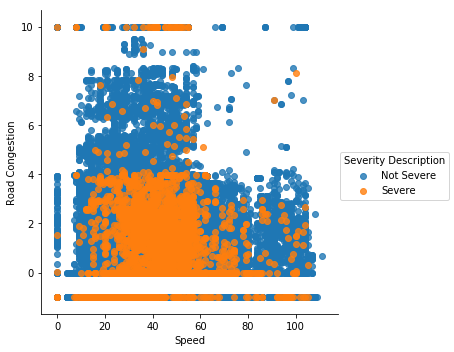

In [15]:
sns.lmplot(x='Speed',y='Road Congestion',hue='Severity Description',data=df,fit_reg=False)
plt.show()

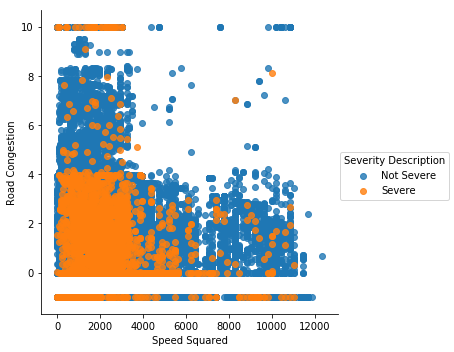

In [11]:
sns.lmplot(x='Speed Squared',y='Road Congestion',hue='Severity Description',data=df,fit_reg=False)
plt.show()

### Speed vs Road Length vs Severity 

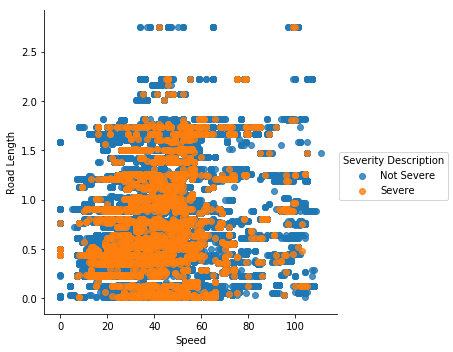

In [7]:
sns.lmplot(x='Speed',y='Road Length',hue='Severity Description',data=df,fit_reg=False)
plt.show()

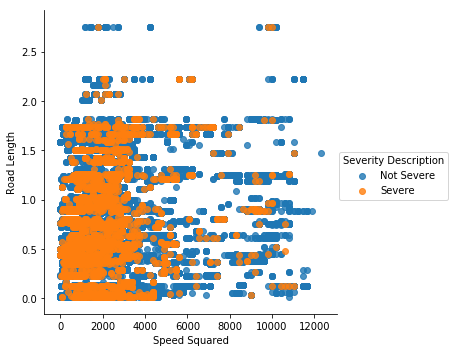

In [13]:
sns.lmplot(x='Speed Squared',y='Road Length',hue='Severity Description',data=df,fit_reg=False)
plt.show()

### Road Length vs Road Congestion vs Severity

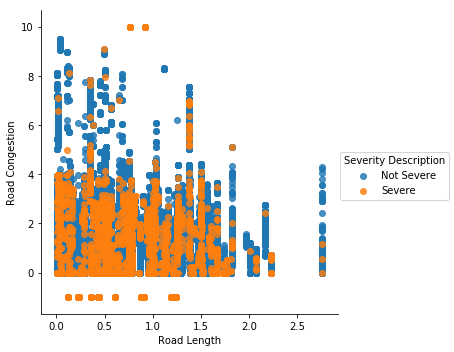

In [8]:
sns.lmplot(x='Road Length',y='Road Congestion',hue='Severity Description',data=df,fit_reg=False)
plt.show()

In [219]:
le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Weather'] = le.fit_transform(df_binary_base_model['Weather'])
df_binary_base_model['Road Condition'] = le.fit_transform(df_binary_base_model['Road Condition'])
df_binary_base_model['Light Condition'] = le.fit_transform(df_binary_base_model['Light Condition'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])

df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Num People Square,Day of the Week
0,0,Not Severe,4,2,3,2,3,7,48.0,2.36674,0.56104,7,4,6
1,0,Not Severe,4,2,3,1,3,12,85.0,-1.00000,0.36276,8,1,3
2,0,Not Severe,4,1,0,2,3,5,13.0,-1.00000,0.36276,8,4,1
3,0,Not Severe,4,2,3,1,3,12,58.0,0.00000,1.73291,8,4,4
4,0,Not Severe,4,0,0,1,3,9,55.0,1.57819,0.74738,11,4,0


In [223]:
#One hot encoding
df_ohe = pd.concat((df_binary_base_model[['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Weather','Light Condition',
                                         'Road Condition']],
          pd.get_dummies(df_binary_base_model, columns=['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Weather','Light Condition',
                                         'Road Condition'], drop_first=True)),
          axis=1)

df_ohe = df_ohe.drop(['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Weather',
                          'Road Condition','Light Condition'],axis=1)

df_ohe.head()

,Severity Description,Speed,Road Congestion,Road Length,Num People Square,Address Type_1,Junction Type_1,Junction Type_2,Junction Type_3,Junction Type_4,...,Weather_2,Weather_3,Weather_4,Light Condition_1,Light Condition_2,Light Condition_3,Light Condition_4,Road Condition_1,Road Condition_2,Road Condition_3
0,Not Severe,48.0,2.36674,0.56104,4,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
1,Not Severe,85.0,-1.00000,0.36276,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
2,Not Severe,13.0,-1.00000,0.36276,4,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,Not Severe,58.0,0.00000,1.73291,4,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
4,Not Severe,55.0,1.57819,0.74738,4,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


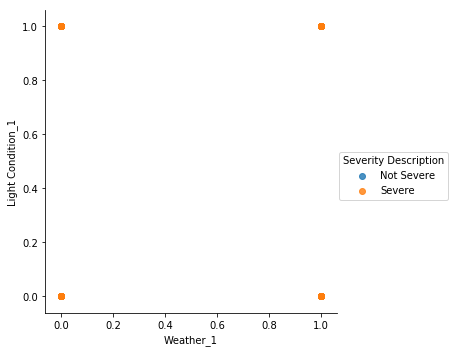

In [224]:
sns.lmplot(x='Weather_1',y='Light Condition_1',hue='Severity Description',data=df_ohe,fit_reg=False)
plt.show()

### Things that improved base model: 
- Removing *Neighborhood* variable -> AUC=0.654
- Optimizing parameters using grid search => num_leaves=50, max_depth=5 -> AUC=0.659
- No change with lgb = LGBMClassifier(max_depth=5,min_data_in_leaf=1000,num_leaves=30,objective='binary')
- No change with max_depth=10,min_data_in_leaf=10000,num_leaves=30,objective='binary'
- Got worse at lgb = LGBMClassifier(learning_rate=0.01,max_depth=5,min_data_in_leaf=1000,num_leaves=30,objective='binary')
- Better model -> lgb = LGBMClassifier(num_leaves=10, max_depth=5,objective='binary') -> AUC=0.66


- Splitting by year did not appear to improve the model

- Determine misclassification error
- Plot curves of predictions with train and test data in order to find optimal point for compromise between over-fitting and under-fitting